# Counting threshold exceedance events
## Cal-Adapt Analytics Engine: threshold tools

This notebook demonstrates four methods for calculating exceedance events (time periods above a certain threshold) at hourly and daily time scales using the `explore_exceedance()` tool. For any given location (and any number of scenarios and simulations) using hourly data, we can calculate and display:
1. Number of hours in a year above a threshold (e.g. hours where the temperature is above 95 degF)
2. Number of days in a year with at least one hour above a threshold (e.g. number of days where the temperature is above 100 degF for at least an hour)
3. Number of multiday events in each year where the temperature exceeds a threshold for the entire duration of the event (e.g. number of 3-day periods where the temperature is consistently above 80 degF).
4. Number of multiday events in each year the temperature exceeds a threshold for at least one hour each of the three days (e.g. number of 3-day periods where each day at least one hour was above 100 degF). 

The tools in this notebook can be used to count exceedance events using different criteria for the threshold to exceed (a particular temperature, for example asset limitations during cold snaps or heat waves) and duration (6 days instead of 3 days characterizing an exceedance event).

## Step 0: setup
Import the [climakitae](https://github.com/cal-adapt/climakitae) library and other dependencies.

In [ ]:
import panel as pn
pn.extension()

# !pip install -v --upgrade git+https://github.com/cal-adapt/climakitae.git
!pip install /home/jovyan/climakitae/

#install needed package to calculate parameters for extreme distributions via l-moments
#climakitae includes lmoments 1.0.1, which references scipy functionality which has been depreciated
#command below installs lmoments 1.0.4 which does not make references to missing/depreciated values
!pip install git+https://github.com/OpenHydrology/lmoments3.git

%load_ext autoreload
%autoreload 2

import climakitae as ck
from climakitae import threshold_tools
import xarray as xr

## Step 1: Select data
### Load a new application and call *select* to display interface from which to choose location, variables, scenarios, and designate warming levels of interest

For the example in this notebook, select:
- Hourly data
- Any desired time slice
- Any scenario(s) of interest (with or without historic data)
- Use the "Air Temperature at 2m" variable with degF units
- Any grid resolution of interest, but 45km will be fastest (note that 3, 9, and 45km spatial resolutions are not aggregates of each other, so results may differ between reso
- Any location of interest, but select the "area average" option to average by hour across space (or you can subset the retrieved data to one location later)

Consider exploring multiple models and scenarios to explore the range of possible outcomes for the exceedance events you are interested in.

Column
    [0] Row
        [0] Column
            [0] Select(name='Timescale', options=OrderedDict([('hourly', ...]), value='monthly')
            [1] RangeSlider(end=2100, name='Time slice', start=1950, step=1, value=(1980, 2015), value_end=2015, value_start=1980)
            [2] VSpacer()
            [3] Select(name='Variable', options=OrderedDict([('Air Tempera...]), value='Air Temperature at 2m')
            [4] StaticText(value="Temperature o...)
            [5] VSpacer()
            [6] StaticText(value='Variable Units')
            [7] RadioButtonGroup(name='Units', options=OrderedDict([('K', ...]), value='K')
            [8] StaticText(value='Model Resolution')
            [9] RadioButtonGroup(name='Resolution', options=OrderedDict([('9 km', ...]), value='9 km')
            [10] Checkbox(name='Area average')
            [11] VSpacer()
        [1] Column
            [0] ParamMethod(method)
            [1] CheckBoxGroup(name='Scenario', options=OrderedDict([('Historical ...]), value=['Historical Climate'])
            [2] Checkbox(name='Append historical')
    [1] Row
        [0] Column(margin=5, name='Location Selections', width=300)
            [0] StaticText(value='<b>Location S...)
            [1] Select(name='Area subset', options=OrderedDict([('none', ...]), value='none')
            [2] RangeSlider(end=67, name='Latitude', start=10, value=(32.5, 42), value_end=42, value_start=32.5)
            [3] RangeSlider(end=-84.18701, name='Longitude', start=-156.82317, value=(-125.5, -114), value_end=-114, value_start=-125.5)
            [4] Select(name='Cached area', options=OrderedDict([('CA', ...]), value='CA')
        [1] ParamMethod(method)
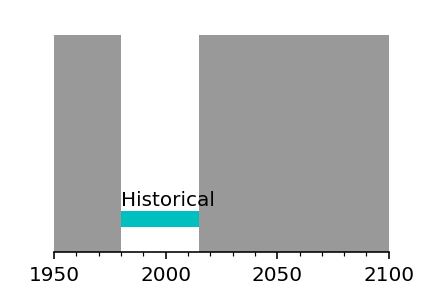
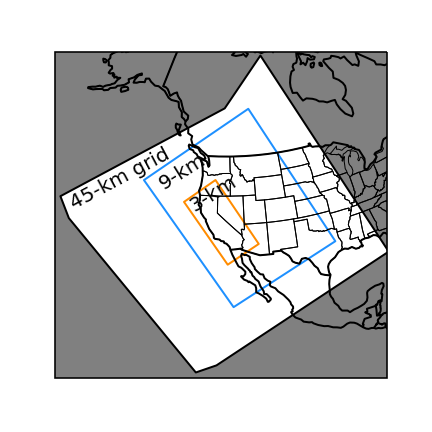

In [2]:
app = ck.Application()
app.select()

## Step 2: Retrieve data

In [3]:
selected_data = app.retrieve()

In [ ]:
# Optionally view the selected data to check if dimensions and attributes are as expected
selected_data

After retrieval, we want to load the data locally with the `.compute()` function. This step will be slow, but will allow for faster computation in our tool later.

In [5]:
selected_data = selected_data.compute()

## Step 3: Explore threshold exceedance events and plot

The exceedance calculator can be used to measure exceedance events based on four different parameters: threshold to capture events above (e.g. temperatures above 80 degF), period (time period for counting number of events during in units of years - e.g. events per 1 year), group (unit of time to measure events), and duration (length of the event - for example to measure multi-day heat events, set this to the number of days you want to consider a heat event). We will invoke the explore tool in the following code cell. If multiple models, runs, or scenarios are provided, the explore tool will plot number of exceedance events in each model/scenario as separate lines. 

Four examples of exceedance events and the calculator options corresponding to each event are described below.

**Example 1: Number of hours in each year above 95 degF** \
This is the most basic specification, where it will just count the number of data points in the hourly data that exceed the threshold value, and sum the count in each year. For this example, select:
- Threshold value: 95, threshold direction: above
- Period: 1 year
- Group: leave as is (this defaults to 1 hour because we are counting the number of hours that qualify as a threshold event)
- Duration: leave as is

**Example 2: Number of days in each year with at least one hour above 95 degF** \
In this specification, instead of returning the total number of hours in each year that exceed the threshold, the user requests the number of days in each year that have at least one hour exceeding the threshold. This is achieved by modifying the "group" option. For this example, select:
- Threshold value: 95, threshold direction: above
- Period: 1 year
- Group: 1 day (because we are counting the number of days that contain a threshold event)
- Duration: leave as is

**Example 3: Number of 3-day long events in each year where it is continuously above 80 degF** \
This could be useful for exploring heat events where night time temperatures never go below some value. In this specification, we introduce the "duration" option. For this example, select:
- Threshold value: 80, threshold direction: above
- Period: 1 year
- Group: leave as is (defaults to 1 hour; because we are interested in _continous_ exceedance of the threshold in this example, so all hours must be above the threshold to qualify as an event. This is in contrast to Example 4 below.)
- Duration: 3 day

**Example 4: Number of 3-day long events in each year where each day has at least one hour above 95 degF** \
For this example, select:
- Threshold value: 95, threshold direction: above
- Period: 1 year
- Group: 1 day (because we are counting the number of days that contain a threshold event)
- Duration: 3 day

**Note** the GUI below will automatically update depending on selections in each panel, but will take a few seconds to reflect new changes.

In [6]:
# invoke the GUI with our selected data and make selections manually
threshold_tools.explore_exceedance(selected_data)

Row
    [0] Column(background='WhiteSmoke', width=400)
        [0] Card(title='Threshold')
            [0] Markdown(str)
            [1] Row(width=400)
                [0] FloatInput(name='Value')
                [1] Select(name='Direction', options=OrderedDict([('above', ...]), value='above')
        [1] Card(title='Period')
            [0] Markdown(str)
            [1] Row(width=400)
                [0] FloatInput(start=0, value=1)
                [1] Select(options=OrderedDict([('year', ...]), value='year')
        [2] Card(title='Group')
            [0] Markdown(str)
            [1] Row(width=400)
                [0] FloatInput(start=0, value=1)
                [1] Select(options=OrderedDict([('year', ...]), value='hour')
        [3] Card(title='Duration (not y...)
            [0] Markdown(str)
            [1] Row(width=400)
                [0] FloatInput(start=0, value=3)
                [1] Select(options=OrderedDict([('year', ...]), value='day')
    [1] ParamMethod(method)

## To do: implement and show download option